In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.base.model
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
import ml_metrics as metrics       # эта метрика вообще нужна?
from itertools import product
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
#import xgboost as xgb


/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import bokeh
output_notebook()

Loading BokehJS ...

In [3]:
def get_table(file):
    df = pd.read_csv(file, ",", parse_dates=['Date'], dayfirst=True)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    df = df.drop('index', 1)
    print( df.head())
    return df

In [4]:
def show_plot(df):
    s1 = figure(plot_width=850, plot_height=250,x_axis_type="datetime")
    s1.line(df.index, df['Value'], line_color='blue')
    
    plt.figure(figsize=(15, 4))
    layout = (1, 2)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (0, 1))

    smt.graphics.plot_acf(df['Value'], lags=30, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(df['Value'], lags=30, ax=pacf_ax, alpha=0.5)
    
    show(s1)

In [5]:
def decomposition(df, model):
    x = df.index
    r = statsmodels.tsa.seasonal.seasonal_decompose(df, model=model)
    
    s = figure(plot_width=850, plot_height=450,x_axis_type="datetime", x_axis_label='Time', y_axis_label='Value')
    s.line(x, r.seasonal['Value'], legend="Seasonal component", line_color='red')
    s.line(x, r.trend['Value'], legend="Trend", line_color='blue') 
    s.line(x, r.resid['Value'], legend="Lags", line_color='grey')
    s.legend.location = "top_left"
    
    show(s)
       
    return r.resid, r.trend, r.seasonal

In [7]:
def stationarity_test(df):
    x = df.index
    rollmean = df.rolling(window=12).mean()
    ewma = df.ewm(halflife=12).mean()
    rolstd = df.rolling(window=12).std()

    p = figure(plot_width=850, plot_height=500,x_axis_type="datetime", x_axis_label='Time', y_axis_label='Value')

    p.line(x, df['Value'], legend="df", line_color='green')
    p.line(x, rollmean['Value'], legend="rollmean", line_color='blue') 
    p.line(x, ewma['Value'], legend="ewma", line_color='red')
    p.line(x, rolstd['Value'], legend="rolstd", line_color='orange')
    p.legend.location = "top_left"
    show(p)
    
    df = df.dropna()
    test = sm.tsa.adfuller(df['Value'])
    print ( 'adf: ', test[0])
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')
    

In [8]:
df = get_table('training.csv')
df2 = get_table('testing.csv')
df2.shape

              Value
Date               
1959-01-01  22.8331
1959-02-01  23.2802
1959-03-01  23.6156
1959-04-01  24.1186
1959-05-01  24.4820
              Value
Date               
1989-01-01  64.6158
1989-02-01  64.3268
1989-03-01  64.4548
1989-04-01  64.5270
1989-05-01  64.0662


(60, 1)

In [9]:
stationarity_test(df)

adf:  -0.253391179928
p-value:  0.931851042299
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
есть единичные корни, ряд не стационарен


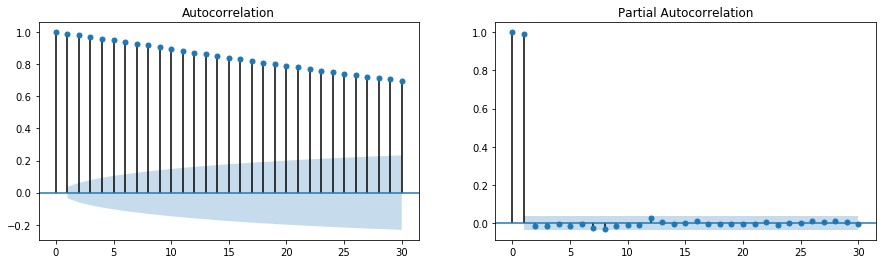

In [10]:
show_plot(df)

## Аддитивная модель

In [11]:
aresid, atrend, aseasonal = decomposition(df, 'additive')

## Мультипликативная модель

In [12]:
residual, trend, seasonal = decomposition(df, 'multiplicative')

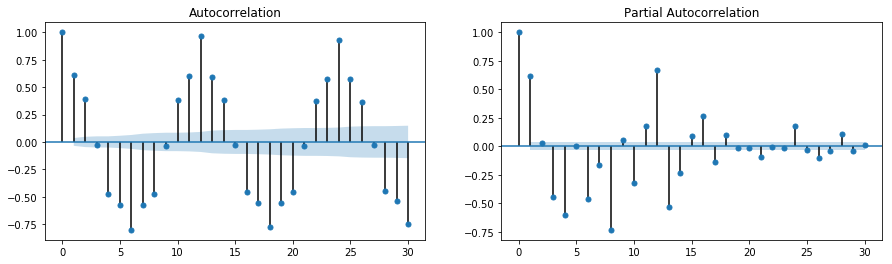

In [43]:
show_plot(seasonal)

Заметим, что в мультипликативной модели меньше разброс ошибок

## Анализ стационарности ряда первых разностей

In [123]:
df1 = df.diff(periods=1).dropna()
df1.head()

,Value
Date,
1959-02-01,0.4471
1959-03-01,0.3354
1959-04-01,0.5030
1959-05-01,0.3634
1959-06-01,0.0279


In [189]:
stationarity_test(df1)

adf:  -7.36731149521
p-value:  9.1641495611e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
единичных корней нет, ряд стационарен


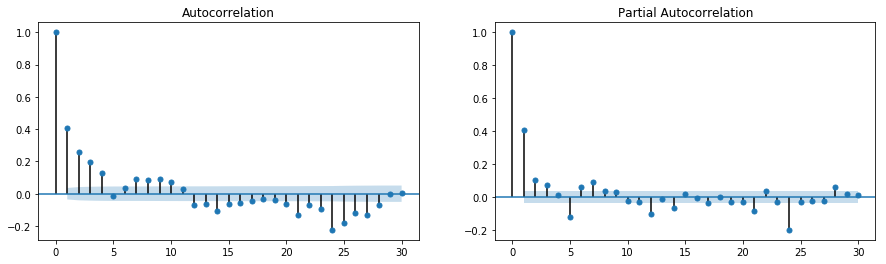

In [187]:
show_plot(df1) #интегрированный ряд первого порядка, его автокореляция и частичная автокорелляция

In [15]:
train, test = df.Value[0:-30], df.Value[329:]

In [46]:
ps = range(0, 10)
qs = range(0, 10)


parameters = product(ps, qs)
parameters_list = list(parameters)

predictions = list()
#results = []
best_r2 = -1000


for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.SARIMAX(train, order=(1,1,1), seasonal_order=(param[0],0,param[1],12)).fit()
        p = model.predict(start=330, end=360, typ='levels')
        r2 = r2_score(test, p)
        #model=sm.tsa.ARIMA(train, order=(param[0], 1, param[1])).fit()
    except ValueError:
        continue
    #print(r2)
    if r2 > best_r2:
        best_model = model
        best_r2 = r2
        best_param = param
        #results.append([param, model.aic])


  6%|▌         | 6/100 [00:08<02:06,  1.34s/it]/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/tsa/statespace/sarimax.py:928: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 24%|██▍       | 24/100 [00:34<01:49,  1.44s/it]/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 25%|██▌       | 25/100 [00:42<02:07,  1.70s/it]/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retval

In [47]:
print(best_r2, best_param)

-2.59809419732 (2, 5)


In [158]:
model = sm.tsa.ARIMA(train, order=(3,1,2)).fit()
print(model.summary())

pred = model.predict(start=330, end=360, typ='levels')
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(pred, test))

p = figure(plot_width=600, plot_height=300,x_axis_type="datetime")

p.line(df.index, test, legend="test")
p.line(df.index, pred, legend="pred", color = 'red', line_dash="4 4")
show(p)
#test.plot()
#pred.plot(style='r--')

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  329
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -112.299
Method:                       css-mle   S.D. of innovations              0.340
Date:                Thu, 07 Dec 2017   AIC                            238.598
Time:                        14:26:54   BIC                            265.170
Sample:                    02-01-1959   HQIC                           249.199
                         - 06-01-1986                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1046      0.037      2.818      0.005       0.032       0.177
ar.L1.D.Value     0.4501      0.279      1.612      0.108      -0.097       0.997
ar.L2.D.Value    -0.6051      0.191     

C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 360), ('y', 31)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 360), ('y', 31)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: 0.05
264.183828555


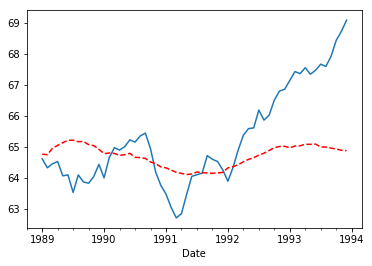

In [39]:
model1 = sm.tsa.SARIMAX(df.Value, order=(2, 1, 2), seasonal_order=(9, 0, 5, 6)).fit()
pred = model1.predict(start = 360, end=419, dynamic=True)
r2 = r2_score(df2['Value'], pred)
print ('R^2: %1.2f' % r2)
print(model1.aic)

df2['Value'].plot()
pred.plot(style='r--')

/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: 0.57
252.380769138


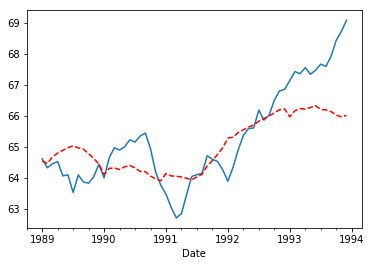

In [41]:
model1 = sm.tsa.SARIMAX(df.Value, order=(1, 1, 1), seasonal_order=(8, 0, 5, 12)).fit()
pred = model1.predict(start = 360, end=419, dynamic=True)
r2 = r2_score(df2['Value'], pred)
print ('R^2: %1.2f' % r2)
print(model1.aic)

df2['Value'].plot()
pred.plot(style='r--')

/anaconda/lib/python3.6/site-packages/statsmodels-0.8.0-py3.6-macosx-10.7-x86_64.egg/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: 0.18
1.40952338717


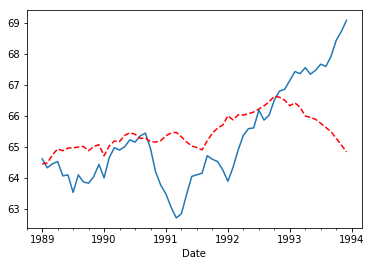

In [45]:
model2 = sm.tsa.SARIMAX(df.Value, order=(1, 1, 1), seasonal_order=(14, 0, 6, 12)).fit()
pred = model2.predict(start = 360, end=419, dynamic=True)
r2 = r2_score(df2['Value'], pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(df2['Value'],pred))

df2['Value'].plot()
pred.plot(style='r--')

### Обучение модели с лучшими параметрами. Получение предсказаний.

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: 0.58
1.00555174686


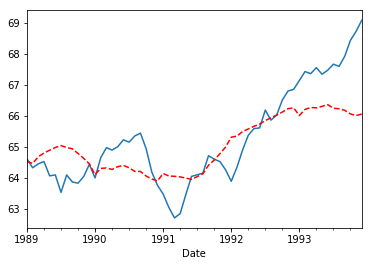

In [186]:
model1 = sm.tsa.SARIMAX(df.Value, order=(1, 1, 1), seasonal_order=(8, 0, 5, 12)).fit()
pred = model1.predict(start = 360, end=419, dynamic=True)
r2 = r2_score(df2['Value'], pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(df2['Value'],pred))

df2['Value'].plot()
pred.plot(style='r--')

### Построение изначальных и предсказанных данных 

In [42]:
p = figure(plot_width=600, plot_height=300,x_axis_type="datetime")

p.line(df.index, df.Value)
p.line(df2.index, pred, color = 'red', line_dash="4 4")
p.line(df2.index, df2.Value, color = 'orange')
show(p)

#df['Value'].plot()
#df2['Value'].plot()
#pred.plot(style='r--')